# Qualifications analysis for data jobs
#### TeamBanov
#### Henriett Kapui, Aleksandar Banov, Matthias Humer



Problem Overview:
Finding top skills for common roles in data science (Machine learning engineer, Data Scientist, Data Analyst, Data Engineer).

**This notebook** In this notebook we are going to conduct an analysis on the US_data that we have gathered for the time period of oct. 2020 to dec. 2021

### Setup Spark 
- **Load Spark with the respective path** 
Set path where Spark is installed (differences in between paths with windows / linux) 

- **Create Spark Session** 
Either take the existing sesseion or create a new one if there is none. Create session based on the parameters.

- **Load SparkContext** 
Context as main entry point for Spark functionality, which we will need later

In [706]:
# Import the findspark module 
import findspark

# Initialize via the full spark path
#findspark.init("/usr/local/spark/")
findspark.init()

In [707]:
# Import the SparkSession module
from pyspark.sql import SparkSession

# Import the collections module
import collections

# Gets an existing :class:`SparkSession` or, if there is no existing one, creates a
# new one based on the options set in this builder.
spark = SparkSession.builder \
   .master("local[8]") \
   .appName("RatingsHistogram") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.
sc = spark.sparkContext


### Read in the datasets in parts and do the preprocecssing steps

- **Load CSV file.**
We read the already preprocessed CSV file.

Note: that we use spark to load the file but then directly move to pandas this is because we had some errors trying to load the spark preprocessed file directly to pandas (there were some bad lines). 

We preprocessed the file by combining 5 datasets from data.world and extracting the relevant job titles. Here's the datasets:
- [oct-dec 2021](https://data.world/promptcloud/indeed-usa-job-listing-data)
- [july-sept 2021](https://data.world/promptcloud/job-data-usa-indeed)
- [apr-jun 2021](https://data.world/promptcloud/usa-indeed-job-data)
- [jan-march 2021](https://data.world/promptcloud/indeed-usa-job-listing-dataset)
- [oct-dec 2020](https://data.world/promptcloud/indeed-usa-job-listing)

In [708]:
# imports
import pandas as pd
import numpy as np

# imports for plots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle,Circle
from matplotlib.lines import Line2D

# imports to do the wordcloud and for all the regular expressions
from wordcloud import WordCloud
import regex as re

# csv to spark df
df = spark.read.csv('US_Jobs.csv')

# list of column names
Data_list = ["city","company_name","crawl_timestamp","inferred_salary_from","inferred_salary_time_unit","inferred_salary_to",\
               "inferred_state","is_remote","job_description","job_title","job_type","post_date","salary_offered","state"]
# place the column names
df = df.toDF(*Data_list)

# spark to pandas df
df = df.toPandas()

df.head()

,city,company_name,crawl_timestamp,inferred_salary_from,inferred_salary_time_unit,inferred_salary_to,inferred_state,is_remote,job_description,job_title,job_type,post_date,salary_offered,state
0,Santa Clara,Intel,2020-11-01 02:08:37 +0000,None,None,None,California,false,Job Description Intel develops best in class g...,Machine Learning Engineer,Temporary,2020-11-01,None,CA
1,Denver,Iontra LLC,2020-11-07 06:02:05 +0000,65000.0,yearly,75000.0,Colorado,true,Data Analyst Research and Development Team - D...,Machine Learning Engineer,Full-time,2020-11-07,"Pay: $65,000.00 - $75,000.00 per year",CO
2,San Diego,Lytx,2020-10-17 13:48:41 +0000,None,None,None,California,false,Innovation Lives Here You go all in no matter ...,Machine Learning Engineer,Full-time,2020-10-17,None,CA
3,(function(_){_.__JS_ERROR__=[];_.onerror=funct...,State Farm,2020-12-02 15:28:30 +0000,None,None,None,None,true,Overview: We are not just offering a job but a...,Machine Learning Engineer,Full-time,2020-12-02,None,'+'pageId:'+e+'
4,Alpharetta,TSYS,2020-10-16 12:20:51 +0000,None,None,None,Georgia,false,"Every day, Global Payments makes it possible f...",Machine Learning Engineer,Full-time,2020-10-16,None,GA


Apply a cleaning function. Luckly we don't have a bunch of html tags in our data

In [709]:
# uses re library for regular expressions
def row_clean(row):
    row = str(row)                        # to string
    row = row.replace("-", " ")           # get's rid of hyphens 
    row = re.sub("[\n]", " ", row)        # get's rid of new lines
    row = re.sub("[.!?\()-,:]", "", row) # get's rid of nonempty sequence of characters from the set of given characters (some are escaped)
    row = row.lower()                     # lowercases the data
    return row

#apply the function above ot the job_description data to make a new column
df["clean_description"] = df["job_description"].apply(row_clean)

df["clean_description"]

0      job description intel develops best in class g...
1      data analyst research and development team   d...
2      innovation lives here you go all in no matter ...
3      overview we are not just offering a job but a ...
4      every day global payments makes it possible fo...
                             ...                        
714    position title  business intelligence data ana...
715    chaossearch is a well funded startup that sign...
716    passionate about low code great with data join...
717    posted 08 nov 2021 service line gws segment ro...
718    come grow with us be part of our mission to em...
Name: clean_description, Length: 719, dtype: object

### Level of education

First we would like to know what level of education is required for data jobs in general.

We are going to use word embeddings to get the level how many possition require the 3 main academic titles (Bachlors, Masters and PhDs). As we have discussed in the notebook with Spark NLP models a word embedding is an approach to provide a dense vector representation of words that capture something about their meaning. Word embeddings algorithms are key to the state-of-the-art results achieved by neural network models on natural language processing problems but here we aren't building anything like that!

In [710]:

import nltk
from gensim.models import Word2Vec
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

# required download
nltk.download('punkt')

# 2 containters
sentences = []
sent_word_sets = []
for row in df.iterrows():                   # itterate through the rows
    desc = row[1].clean_description         # get second element of tuple which is the whole row and select the value of the clean_description column
    word_tokens = nltk.word_tokenize(desc)  # Return a tokenized copy the text
    sentences.append(word_tokens)           # saves the tokens into sentenses
    sent_word_sets.append(set(word_tokens)) # make a set of the tokens (no duplicates)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [711]:
# initialize the model 
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count= 1, workers=4)

In [712]:
# container
possible_words = set()

# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('bachelor', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0]) 
similar_words

[('degree', 0.9218458533287048),
 ('master', 0.9204626083374023),
 ('education', 0.9023189544677734),
 ('ba', 0.9001022577285767),
 ('bachelors', 0.8861169815063477),
 ('qualifications', 0.8755502700805664),
 ('phd', 0.8660872578620911),
 ('ba/bs', 0.8599230647087097),
 ('enrolled', 0.854404091835022),
 ('bs', 0.8513772487640381),
 ('doctorate', 0.8452516198158264),
 ('outlined', 0.8392623662948608),
 ('masters', 0.8348485827445984),
 ('undergraduate', 0.8307951092720032),
 ('bls', 0.8291796445846558),
 ('qualification', 0.8282220363616943),
 ('scrummaster', 0.827725350856781),
 ('equivalent', 0.8244492411613464),
 ('minimum', 0.8240559101104736),
 ('graduate', 0.8216597437858582),
 ('diploma', 0.8185442686080933),
 ('degree/phd', 0.8070160150527954),
 ('registrar', 0.8058275580406189),
 ('school', 0.8036858439445496),
 ('ms/phd', 0.8004546761512756),
 ('certifications', 0.79975426197052),
 ('discipline', 0.7986593842506409),
 ('higher', 0.7981142401695251),
 ('ged', 0.7964184880256653

In [713]:
# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('masters', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0])
similar_words

[('ba', 0.9549277424812317),
 ('mba', 0.9536921977996826),
 ('math', 0.9459288716316223),
 ('coursework', 0.9393212795257568),
 ('phd', 0.9390607476234436),
 ('discipline', 0.9388119578361511),
 ('graduate', 0.9388046860694885),
 ('jd', 0.9329073429107666),
 ('physics', 0.929174542427063),
 ('degrees', 0.928236722946167),
 ('undergraduate', 0.9221691489219666),
 ('bs', 0.9211053252220154),
 ('bachelors', 0.916449248790741),
 ('nursing', 0.9124814867973328),
 ('higher', 0.9118050932884216),
 ('terminal', 0.9098148345947266),
 ('extensively', 0.9088918566703796),
 ('mathematics', 0.9087387919425964),
 ('master', 0.9077050685882568),
 ('economics', 0.9066896438598633),
 ('econometrics', 0.9066291451454163),
 ('journalism', 0.9058521389961243),
 ('stem', 0.9042565226554871),
 ('biostatistics', 0.9009842872619629),
 ('computer', 0.9006364941596985),
 ('fields', 0.9002167582511902),
 ('equivalent', 0.8985534310340881),
 ('either', 0.8976795077323914),
 ('bls', 0.8964998126029968),
 ('certifi

In [714]:
# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('phd', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0])
similar_words

[('equivalent', 0.9602757096290588),
 ('ba', 0.9598749876022339),
 ('mba', 0.9595839977264404),
 ('discipline', 0.9554934501647949),
 ('degree', 0.9544996619224548),
 ('bs', 0.9494830965995789),
 ('graduate', 0.9454153776168823),
 ('coursework', 0.9404423236846924),
 ('masters', 0.9390608072280884),
 ('diploma', 0.9340263605117798),
 ('certifications', 0.9313259124755859),
 ('field', 0.9310349225997925),
 ('either', 0.9271928668022156),
 ('school', 0.9240339398384094),
 ('bachelors', 0.9186517000198364),
 ('degrees', 0.9185238480567932),
 ('enrolled', 0.9131564497947693),
 ('certification', 0.9107994437217712),
 ('extensively', 0.9096154570579529),
 ('higher', 0.9068097472190857),
 ('undergraduate', 0.9058026075363159),
 ('comparable', 0.9040461778640747),
 ('math', 0.903771698474884),
 ('college', 0.9021409153938293),
 ('fields', 0.9008976221084595),
 ('econometrics', 0.8953415751457214),
 ('nursing', 0.8925848007202148),
 ('master', 0.8920065760612488),
 ('dplyr', 0.88948655128479),


In [715]:
print(possible_words)

{'terminal', 'nursing', 'comparable', 'degree', 'ba', 'qualifications', 'graduate', 'jd', 'stem', 'ms/phd', 'outlined', 'ged', 'higher', 'undergraduate', 'scrummaster', 'college', 'qualification', 'math', 'mathematics', 'economics', 'journalism', 'minimum', 'bs', 'certifications', 'diploma', 'doctorate', 'master', 'school', 'bls', 'dplyr', 'degrees', 'masters', 'equivalent', 'registrar', 'computer', 'pursuing', 'bachelors', 'certification', 'physics', 'either', 'discipline', 'biostatistics', 'extensively', 'ba/bs', 'econometrics', 'enrolled', 'coursework', 'fields', 'phd', 'field', 'education', 'degree/phd', 'mba'}


After taking a look at the output of the **Word2Vec.most_similar** we get a sense how are the different academic titles (Bachlors, Masters and PhDs) written down in the job description.

Now we just make lists with the most common appearing strings that describe the titles we are interested in.

In [716]:
bachelor_list = ['bs','b.s','bsc','bs/ms','bachelor','ba/bs','b.s.','bs/ms/phd','bachelors','ba','bs/ba','undergraduate']
master_list = ['masters','master','bs/ms','m.s.','m.s','msc','bs/ms/phd','ms','md/phd','ms/phd','postgraduate']
phd_list = ['phd','ph.d.','ph.d','bs/ms/phd','md/phd','ms/phd','doctoral','postgraduate','doctorate']

In [717]:
# make a column out of the set of the tokens
df["sent_word_sets"] = sent_word_sets

In [718]:
def has_qual(word_set,qual_list):
    for word in qual_list:   # for each possible word that describes the academic title
        if word in word_set: # check if it matches words from the description
            return True
    return False

In [719]:
# apply to the new column to creat 3 new binary columns that describe the academic title of the job
df["bachelors"] = df["sent_word_sets"].apply(lambda x: has_qual(x,bachelor_list))
df["masters"] = df["sent_word_sets"].apply(lambda x: has_qual(x,master_list))
df["phd"] = df["sent_word_sets"].apply(lambda x: has_qual(x,phd_list))

In [720]:
print(f"Bachelor jobs: {df['bachelors'].sum()}")
print(f"Masters jobs: {df['masters'].sum()}")
print(f"PhD of jobs: {df['phd'].sum()}")

Bachelor jobs: 435
Masters jobs: 237
PhD of jobs: 80


Bulding a nice donut plot to vizualize our results:

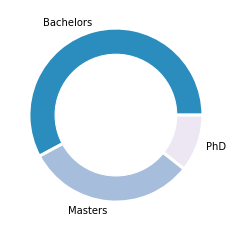

In [721]:
# library
import matplotlib.pyplot as plt
 
# create data
names = ['Bachelors', 'Masters', 'PhD']
size = [df['bachelors'].sum(),df['masters'].sum(),df['phd'].sum()]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(size, labels=names, colors=['#2b8cbe','#a6bddb','#ece7f2'], wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

### Skill Analysis

We can utilize regular expressions to search for a specific programming language, technology, etc.

In [722]:
# convert the column to an array of stirngs
text = df.clean_description.values

In [723]:
# Create a regex search function
def count_text(patt,text):
    pattern = re.compile(patt) # regex pattern to regex object used for matching
    count = 0                  # counter
    for t in text:             # itterate over the strings of all columns
        if pattern.search(t):  # if we find a match for the regex pattern
            count+=1           # we add to the counter
    return count

Programming skills

In [724]:
# Create a data frame with skills name and regex pattern to search with
skills = ['Python','Hadoop','SQL','Tableau','TensorFlow','Agile','Power BI','SSaS','Algorithm','Java','Visualization']

skill_patt = ['(?i)\WPython\W','(?i)\WHadoop\W?','(?i)SQL\w*','(?i)\WTableau\W?',
              "(?i)\WTensorFlow\W?","(?i)\WAgile\W?","(?i)\WPower\s?BI\W?",
             "(?i)\WSSAS\W?","(?i)\WAlgorithms?\W?",'(?i)Java\w*','(?i)\WVisualization\W?']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [725]:
#container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    # append the number of counts to the container
    container.append(count_text(x,text))
    
# assign the container to a column    
skill_df['count'] = container

#calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)
skill_df

,skill,regex_pattern,count,percentage
0,Python,(?i)\WPython\W,337,0.47
1,Hadoop,(?i)\WHadoop\W?,80,0.11
2,SQL,(?i)SQL\w*,375,0.52
3,Tableau,(?i)\WTableau\W?,163,0.23
4,TensorFlow,(?i)\WTensorFlow\W?,54,0.08
5,Agile,(?i)\WAgile\W?,116,0.16
6,Power BI,(?i)\WPower\s?BI\W?,82,0.11
7,SSaS,(?i)\WSSAS\W?,5,0.01
8,Algorithm,(?i)\WAlgorithms?\W?,110,0.15
9,Java,(?i)Java\w*,144,0.20


C:\Users\Asus\AppData\Local\Temp/ipykernel_8784/1080612751.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


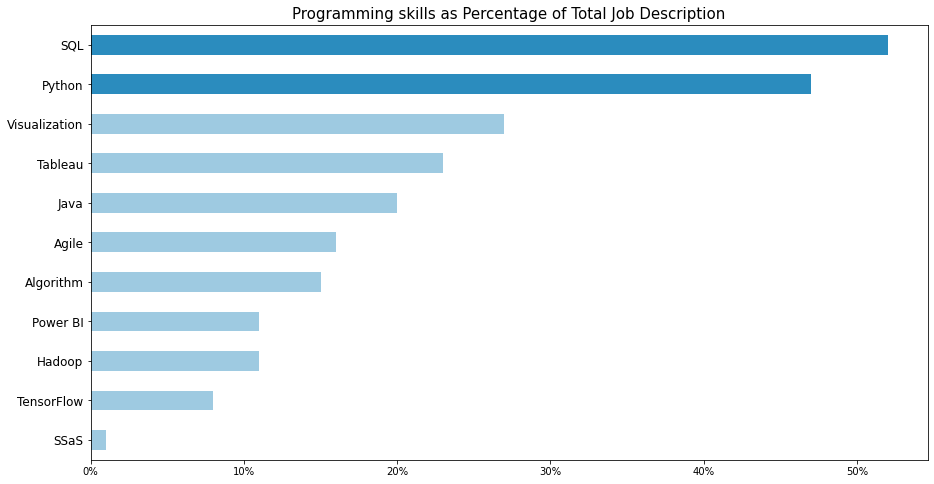

In [726]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8),\
                         color=['#9ecae1','#9ecae1','#9ecae1','#9ecae1',\
                                '#9ecae1','#9ecae1','#9ecae1','#9ecae1','#9ecae1','#2b8cbe', '#2b8cbe'])

ax.set_title('Programming skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])

plt.show()

Cloud Service Providers

In [727]:
# Create a data frame with skills name and regex pattern to search with
skills = ['AWS','Azure','GCP']

skill_patt = ['(?i)AWS\w*','(?i)\WAzure\W?','(?i)GCP\w*']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [728]:
# container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    container.append(count_text(x,text))

# assign the container to a column
skill_df['count'] = container

# calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)
skill_df

,skill,regex_pattern,count,percentage
0,AWS,(?i)AWS\w*,188,0.26
1,Azure,(?i)\WAzure\W?,83,0.12
2,GCP,(?i)GCP\w*,32,0.04


C:\Users\Asus\AppData\Local\Temp/ipykernel_8784/1476302096.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


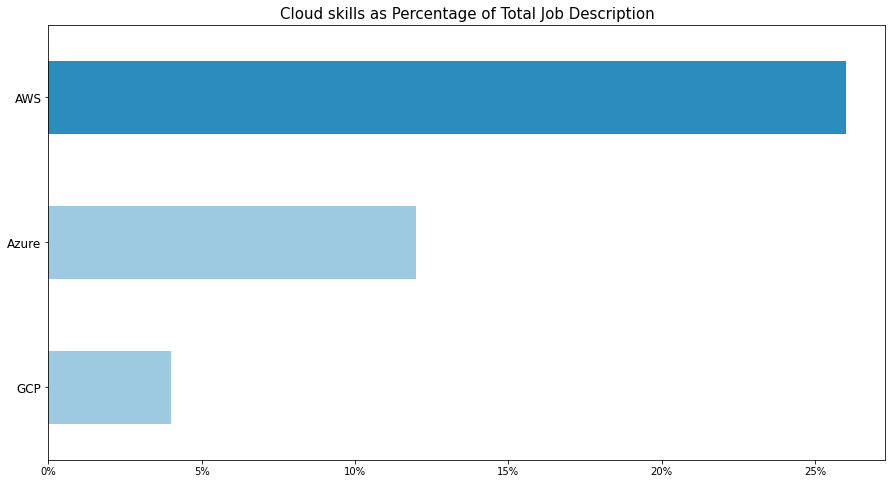

In [729]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8), color=['#9ecae1','#9ecae1','#2b8cbe'])

ax.set_title('Cloud skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.show()


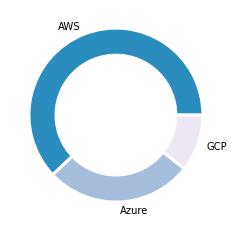

In [730]:
# library
import matplotlib.pyplot as plt
 
# create data
names = ['AWS', 'Azure', 'GCP']
size = skill_df['count'].values.tolist()
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(size, labels=names, colors=['#2b8cbe','#a6bddb','#ece7f2'], wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

Technologies

In [731]:
# Create a data frame with skills name and regex pattern to search with
skills = ['tensorflow','pytorch','spark','keras','opencv','cuda','pandas','matplotlib','tidyverse']

skill_patt = ["(?i)\WTensorFlow\W?","(?i)\WPyTorch\W?","(?i)\WSpark\W?","(?i)\Wkeras\W?","(?i)\Wopencv\W?","(?i)\WCuda\W?",'(?i)\WPandas\W?','(?i)\Wmatplotlib\W?','(?i)Wtidyverse\W?']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [732]:
# container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    container.append(count_text(x,text))
    
# assign the container to a column
skill_df['count'] = container

# calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)

skill_df


,skill,regex_pattern,count,percentage
0,tensorflow,(?i)\WTensorFlow\W?,54,0.08
1,pytorch,(?i)\WPyTorch\W?,36,0.05
2,spark,(?i)\WSpark\W?,130,0.18
3,keras,(?i)\Wkeras\W?,15,0.02
4,opencv,(?i)\Wopencv\W?,1,0.00
5,cuda,(?i)\WCuda\W?,6,0.01
6,pandas,(?i)\WPandas\W?,37,0.05
7,matplotlib,(?i)\Wmatplotlib\W?,5,0.01
8,tidyverse,(?i)Wtidyverse\W?,0,0.00


C:\Users\Asus\AppData\Local\Temp/ipykernel_8784/3952455690.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


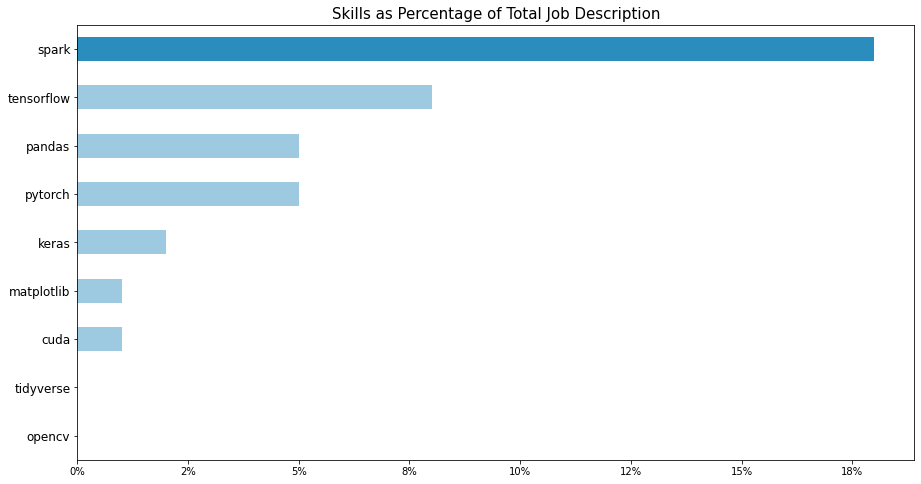

In [733]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8),\
                         color=['#9ecae1','#9ecae1','#9ecae1','#9ecae1',\
                                '#9ecae1','#9ecae1','#9ecae1','#9ecae1','#2b8cbe'])


ax.set_title('Skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])

plt.show()

In [734]:
df['state'].value_counts().head(20)

CA                 101
TX                  59
VA                  43
NY                  40
FL                  36
MA                  32
WA                  27
OH                  26
'+'pageId:'+e+'     23
GA                  23
IL                  23
DC                  19
NC                  18
PA                  17
MD                  17
MI                  17
MN                  15
CO                  14
NJ                  11
WI                   9
Name: state, dtype: int64

In [735]:
# create a dataframe out of the output of the value_counts().
census = df.state.value_counts().rename_axis('unique_values').reset_index(name='counts')

# drop fast unusable data
census = census.drop(census.index[8]) 
census = census.drop(census.index[37])
census = census.drop(census.index[37])
census = census.drop(census.index[59])

# rename columns
census.rename(columns = {'unique_values':'states','counts':'jobs'}, inplace = True)

# Get rid of postal code by taking only the first 2 letters of the strings
def first2(s):
    return s[:2]

census['states']=census['states'].apply(first2)
census.head()

,states,jobs
0,CA,101
1,TX,59
2,VA,43
3,NY,40
4,FL,36


In [736]:
# get a geo json file and match the the feature.id key to the states column of the dataset
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

%pip install folium
import folium

m = folium.Map(location=[48.739890, -100.627899], zoom_start=4)

folium.Choropleth(
    geo_data= state_geo,
    name="choropleth",
    data=census,
    columns=["states", "jobs"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=9,
    
    legend_name="Number of Data jobs per State",
    nan_fill_opacity=0,
).add_to(m)

folium.LayerControl().add_to(m)
m

**Sources:**

Apart form the datasets that are linked in the begining of the notebook here's the additional material we used:
- [RegEx](https://www.codepicky.com/regex/#:~:text=Regex%20is%20one%20of%20the,in%20long%20pieces%20of%20text.&text=Regex%20or%20Regexp%2C%20short%20for,typically%20used%20on%20larger%20texts.)
- [NLTK Doc](https://www.nltk.org/api/nltk.tokenize.html?highlight=word_tokenize#nltk.tokenize.word_tokenize)
- [Plots](https://www.python-graph-gallery.com/)
- [gensim API 1](https://radimrehurek.com/gensim/apiref.html#api-reference)
- [gensim API 2](https://tedboy.github.io/nlps/api_gensim.html)
- [Pretty colors](https://colorbrewer2.org/#type=sequential&scheme=Blues&n=3)
- [NLTK](https://www.nltk.org/book_1ed/ch07.html)
